In [119]:
0.19 / 0.135

1.4074074074074074

In [120]:
332 / 255

1.3019607843137255

In [ ]:
import pandas as pd
import plotly.express as px


# what kind of tollerance is a good goal?


df = pd.read_csv("/Users/pb/Documents/Github/Tokemak/v2-rebalance-dashboard/15_min_auto_usd_combinations2.csv")

df[["sell_amount_norm", "buy_amount_price", "min_buy_amount_price", "label", "datetime_received"]]

,sell_amount_norm,buy_amount_price,min_buy_amount_price,label,datetime_received
0,100000.0,0.998156,0.997806,USDe -> USDC,2025-09-23 19:48:53.318472+00:00
1,100000.0,0.997977,0.997628,USDT -> USDC,2025-09-23 19:48:53.206591+00:00
2,200000.0,0.998487,0.998137,USDT -> GHO,2025-09-23 19:48:53.458206+00:00
3,200000.0,0.994345,0.993997,FRAX -> USDe,2025-09-23 19:48:53.509227+00:00
4,200000.0,1.000237,0.999887,USDT -> FRAX,2025-09-23 19:48:53.372739+00:00
...,...,...,...,...,...
1495,200000.0,0.995174,0.994825,FRAX -> crvUSD,2025-09-23 22:33:53.653599+00:00
1496,200000.0,0.996987,0.996638,USDT -> USDe,2025-09-23 22:33:54.914603+00:00
1497,150000.0,0.996827,0.996478,GHO -> USDC,2025-09-23 22:33:56.624228+00:00
1498,100000.0,0.998333,0.997983,USDe -> USDC,2025-09-23 22:33:57.380607+00:00


In [127]:
spread_df = df.groupby(["label", "sell_amount_norm"]).agg(
    buy_amount_price_min=("buy_amount_price", "min"),
    buy_amount_price_max=("buy_amount_price", "max"),
    min_buy_amount_price_min=("min_buy_amount_price", "min"),
    min_buy_amount_price_max=("min_buy_amount_price", "max"),
)
spread_df["buy_amount_spread_bps"] = 10_000 * (
    (spread_df["buy_amount_price_max"] - spread_df["buy_amount_price_min"]) / spread_df["buy_amount_price_min"]
)
spread_df["min_buy_amount_spread_bps"] = 10_000 * (
    (spread_df["min_buy_amount_price_max"] - spread_df["min_buy_amount_price_min"])
    / spread_df["min_buy_amount_price_min"]
)
spreads = (
    spread_df[["buy_amount_spread_bps", "min_buy_amount_spread_bps"]]
    .reset_index()
    .pivot(index="sell_amount_norm", columns="label", values="buy_amount_spread_bps")
)
px.box(spreads)

In [128]:
spreads

label,FRAX -> GHO,FRAX -> USDC,FRAX -> USDT,FRAX -> USDe,FRAX -> crvUSD,GHO -> FRAX,GHO -> USDC,GHO -> USDT,GHO -> USDe,GHO -> crvUSD,...,USDe -> FRAX,USDe -> GHO,USDe -> USDC,USDe -> USDT,USDe -> crvUSD,crvUSD -> FRAX,crvUSD -> GHO,crvUSD -> USDC,crvUSD -> USDT,crvUSD -> USDe
sell_amount_norm,,,,,,,,,,,,,,,,,,,,,
50000.0,4.348681,4.038268,4.975019,1.689700,4.803480,4.416259,1.659254,1.609922,2.541998,1.303732,...,2.016996,2.610940,2.458459,2.953198,3.078474,4.991994,1.445634,0.889977,1.510260,2.654682
100000.0,3.916257,3.995209,4.829003,1.132441,4.803737,3.644556,1.419728,1.892907,3.073928,1.179621,...,1.336898,2.743643,2.596763,3.197092,3.130094,4.551708,1.562511,1.002770,1.662726,3.051336
150000.0,3.263499,3.330711,3.993904,1.061753,4.013199,4.114629,1.380161,1.788663,2.740246,1.663793,...,1.122485,2.923342,2.825723,3.792896,3.315909,5.445496,1.321157,1.035550,1.363715,3.014198
200000.0,3.632765,3.293254,6.243114,0.989284,3.956692,2.509776,1.150555,1.797320,3.326234,1.722278,...,3.969275,2.198409,2.956951,3.190210,3.009557,4.438372,1.329164,0.600240,1.348937,2.496733
250000.0,3.282364,3.219426,3.786853,0.946509,3.795863,3.900331,1.346343,1.830474,3.471595,1.418450,...,1.032290,2.603788,2.627215,3.667846,3.009017,3.685387,0.665157,0.503674,1.365017,2.813286


In [123]:
df["datetime_received"] = pd.to_datetime(df["datetime_received"])
df["datetime_received"].max() - df["datetime_received"].min()

Timedelta('0 days 02:45:05.453650')

In [124]:
px.scatter(
    df,
    x="sell_amount_norm",
    y="buy_amount_price",
    color="label",
    size="min_buy_amount_price",
    hover_data=["datetime_received"],
)

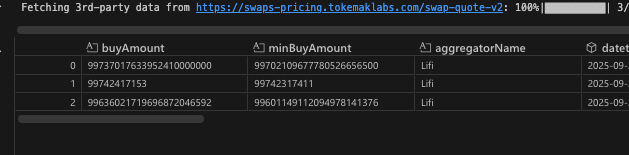

In [125]:
df.columns

Index(['Unnamed: 0', 'buyAmount', 'minBuyAmount', 'aggregatorName',
       'datetime_received', '3rd_party_response_success', 'chainId',
       'systemName', 'slippageBps', 'taker', 'sellToken', 'buyToken',
       'sellAmount', 'includeSources', 'excludeSources', 'sellAll',
       'timeoutMS', 'method', 'url', 'buy_amount_norm', 'min_buy_amount_norm',
       'sell_amount_norm', 'buy_amount_price', 'min_buy_amount_price',
       'buy_symbol', 'sell_symbol', 'label', 'batch_id'],
      dtype='object')

In [126]:
# I have a feeling that the swap matrix is optimizing for the wrong thing, min buy amount vs buy amount?